# Imports and reading the data

In [3]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches 

In [4]:
#reading the data
df = pd.read_csv('escorts.txt', delim_whitespace=True, index_col=False)

df_copy = df.copy()

#creating new columns in df that adds: year, month and day
df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'], unit='s')

df_copy['year'] = df_copy['datetime'].dt.year
df_copy['month'] = df_copy['datetime'].dt.month
df_copy['day'] = df_copy['datetime'].dt.day

#dropping column datetime
df_copy = df_copy.drop(columns=['datetime'])

#getting rid of the timestamp
df_no_time = df.drop('timestamp', axis=1)
df_no_time.to_csv('escorts.csv', index =False, header=False)


### Creating graphs

In [5]:
#creating different IDs for buyers(a) and escorts(b), so the nx function could read it
df_no_time['n1'] = 'a' + df_no_time['n1'].astype(str)

df_no_time['n2'] = 'b' + df_no_time['n2'].astype(str)

#collapsing the edges where one buyer rated the same girl more than 1 time
main_df = df_no_time.groupby(['n1', 'n2'], as_index=False).mean() #yes, it creates the means if they went to more than one escort


In [6]:
#projecting the bipartite graph using vectorized projection
G = nx.from_pandas_edgelist(main_df, 'n1', 'n2', 'e')

#projecting onto the escorts
proj_G = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n2.unique(), ratio=True) #ratio is number of common neighbors devided by number of buyers

#projecting onto the buyers
proj_G_b = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n1.unique(), ratio=True)

# Basic network analysis

### On the bipartite network

In [ ]:
#finding unique number of buyers and escorts
buyers = df.n1.unique().tolist()
escorts = df.n2.unique().tolist()

print(f'Unique edge count: {G.size()}')
print(f'Total number of nodes: {G.number_of_nodes()}')
print(f'Numbers of buyers: {len(buyers)}')
print(f'Numbers of escorts: {len(escorts)}')
print(f'Total number of rows: {df_no_time.shape[0]}') #num of encounters
print(f'Is the network connected? {nx.is_connected(G)}') 

avg_rating = round(float(df_no_time['e'].mean()), 3)
print(f'Average rating: {avg_rating}') #most of them satisfied ;)

Unique edge count: 39044
Total number of nodes: 16730
Numbers of buyers: 10106
Numbers of escorts: 6624
Total number of rows: 50632
Is the network connected? False
Average rating: 0.743


In [ ]:
#Largest Connected Component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
LCC = G.subgraph(Gcc[0])
print(LCC.size())
print(f'Number of unique edges are out of the LCC: {G.size() - LCC.size()}')

38540
Number of unique edges are out of the LCC: 504


In [ ]:
#finding most popular buyers(biggest amount of payments) and escorts(how many times visited)
#we need to observe that the escorts that had less buyers and had rating of 1, will have better scores than the most visited ones
#so we need to normalize it

#on df_no_time, because it contains the edges before collapsing them

#Making dataframe of popular buyers and popular escorts
pop_buyers = df_no_time['n1'].value_counts().reset_index()
pop_escorts = df_no_time['n2'].value_counts().reset_index()

#Making list of the 10 most popular buyers
b_top10 = pop_buyers['index'].head(10).tolist()
 
#Making list of the 10 most popular escorts
e_top10 = pop_escorts['index'].head(10).tolist()

In [ ]:

#Dictionary of average rating of most vistied escorts (top 10 degrees)
#Key: ID of escort
#Value: Average rating
avg = {}
for escort in e_top10:
    most_pop_esc = df_no_time[df_no_time['n2'] == escort]
    ratings = most_pop_esc['e'].tolist()
    avg[escort] = round(sum(ratings)/len(ratings), 3)

print(avg)

{'b11': 0.98, 'b1565': 0.992, 'b1443': 0.96, 'b41': 0.942, 'b1345': 0.968, 'b2845': 0.977, 'b2470': 0.98, 'b1569': 0.953, 'b2799': 0.983, 'b503': 0.955}


In [ ]:
#Average degrees

avg_d_b = round(float(pop_buyers['n1'].mean()), 3)
print(f'Average degree of buyers: {avg_d_b}') #how many ratings they've given

avg_d_e = round(float(pop_escorts['n2'].mean()), 3)
print(f'Average degree of escorts: {avg_d_e}') #how many times they've been rated

Average degree of buyers: 5.01
Average degree of escorts: 7.644


### On the projections

In [ ]:
#number of singletons
degrees = nx.degree(proj_G)

n = 0
for key, value in degrees:
    if value == 0:
        n += 1
print(f'Numbers of singletons: {n}')

Numbers of singletons: 385


In [ ]:
#basic network analysis on projected network
# proj_G.size() #num of edges
print(proj_G.number_of_edges())
print(proj_G.number_of_nodes())

#density it's a range 0-1
print(nx.density(proj_G)) #quite sparse 

183465
6624
0.008363886718878218


In [ ]:
# idea: in order to create more fair rating of escorts (normalize the retings) average the weights of edges of a specific node and
# use it as a weights to use on averaged rating on the node.
# this doesn't work, because it'd favor the most visited nodes

x = (len(G) - len(main_df.n2.unique())) #ratio=True when we project th network
rat1 = 1/x
rat600 = 615/x

#example scores
print(1*rat1)
print(0.98*rat600)

9.895111814763506e-05
0.059637838907579656


In [ ]:
rat1 = 2/3
rat600 = 616/617
rat = 101/102

print(1*rat1)
print(0.98*rat600)
print(0.4*rat)

0.6666666666666666
0.9784116693679092
0.39607843137254906


### Laplace's Rule of Succesion 

In [ ]:
# Define Laplace's Rule of Succession function with weighted ratings
def laplace_rule_of_succession(df, rating_weights={'positive': 1, 'neutral': 0.5, 'negative': -1}):
    # Calculate the total number of reviews for each escort
    reviews_count = df.groupby('n2')['e'].count().reset_index()
    reviews_count.rename(columns={'e': 'TotalReviews'}, inplace=True)

    # Calculate the total weight for each escort
    weighted_reviews = df.groupby(['n2'])['e'].sum().reset_index()
    weighted_reviews.rename(columns={'e': 'TotalWeight'}, inplace=True)

    # Merge the weight information back into the main dataframe
    df = pd.merge(df, reviews_count, on='n2', how='left')
    df = pd.merge(df, weighted_reviews, on='n2', how='left')

    # Calculate Laplace-adjusted ratings with weighted ratings
    df['LaplaceAdjustedRating'] = (df['TotalWeight'] + rating_weights['positive']) / (df['TotalReviews'] + sum(rating_weights.values()))

    return df



In [ ]:
df_test = laplace_rule_of_succession(main_df)
df_test

,n1,n2,e,TotalReviews,TotalWeight,LaplaceAdjustedRating
0,a1,b1,0.0,47,18.50,0.410526
1,a1,b1057,-1.0,83,65.25,0.793413
2,a1,b12,0.0,85,65.00,0.771930
3,a1,b130,-1.0,16,-9.00,-0.484848
4,a1,b1340,-1.0,63,46.00,0.740157
...,...,...,...,...,...,...
39039,a9996,b1503,1.0,36,28.00,0.794521
39040,a9997,b125,1.0,22,22.00,1.022222
39041,a9998,b1569,1.0,270,252.00,0.935305
39042,a9998,b4791,1.0,22,21.00,0.977778


## Degree distribution

In [ ]:
#degrees in the bipartite network
bi_escorts_degrees = Counter(main_df['n2'])

bi_buyers_degrees = Counter(main_df['n1'])

#degrees in the projected
escorts_degrees = dict(proj_G.degree())
buyers_degrees = dict(proj_G_b.degree())

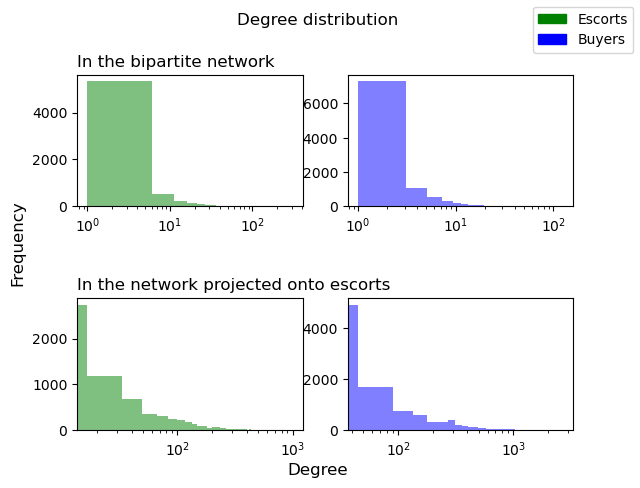

In [ ]:
#Plotting degree distribution
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(bi_escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color='g')
ax[0,0].set_xscale('log')

ax[0, 1].hist(bi_buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = 'b')
ax[0,1].set_xscale('log')

ax3 = ax[1, 0].hist(escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color ='g')
ax[1,0].set_xscale('log')

ax4 = ax[1, 1].hist(buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = 'b')
ax[1,1].set_xscale('log')

fig.supxlabel('Degree')
fig.supylabel('Frequency')

green_patch = mpatches.Patch(color='g', label='Escorts') 
blue_patch = mpatches.Patch(color='b', label='Buyers') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 
ax[0,0].set_title('In the bipartite network', loc='left')
ax[1,0].set_title('In the network projected onto escorts', loc='left')
fig.suptitle('Degree distribution')
fig.subplots_adjust(hspace=0.7, top=0.85)

plt.show()

### Cumulative degree distribution

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) #the degree of each nod

In [ ]:
# accumulating the degrees from highest to lowest
cumulative_degrees = [degree_sequence[:i].count(degree) for i, degree in enumerate(degree_sequence)]

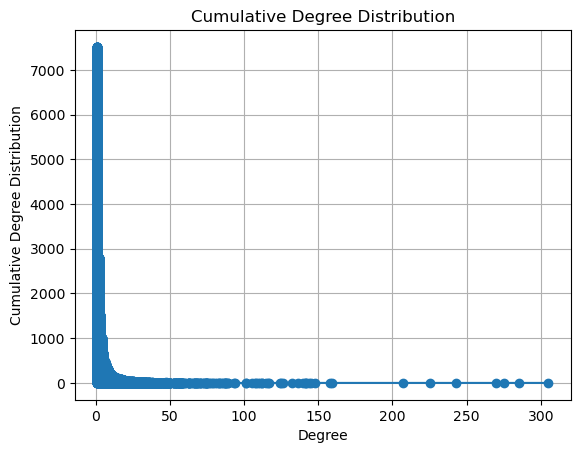

In [ ]:
plt.plot(degree_sequence, cumulative_degrees, marker='o')
plt.xlabel("Degree")
plt.ylabel("Cumulative Degree Distribution")
plt.title("Cumulative Degree Distribution")
plt.grid(True)
plt.show()

# Calculating centralities to detect the hubs of the network

### Degree centrality

In [ ]:
d_cent = nx.degree_centrality(proj_G)

#top 10
d_c_sorted = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

### Betweenness centrality

In [ ]:
b_cent = nx.betweenness_centrality(proj_G, k=1000)

#top 10
b_c_sorted = {k: v for k, v in sorted(b_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

In [ ]:
#wtf are the endpoints about???
# b_cent = nx.betweenness_centrality(proj_G, k=10, endpoints=True)
# sortt = {k: v for k, v in sorted(b_cent.items(), key=lambda item: item[1], reverse=True)[:10]}
# sortt

### Closeness centrality

In [ ]:
c_cent = nx.closeness_centrality(proj_G)

#top 10
c_c_sorted = {k: v for k, v in sorted(c_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

In [ ]:
#the algorithm was designed for directed graph, but it gives us some idea of hubs
hity = nx.hits(proj_G)
hity = dict(hity[0])

#top 10
hits_sorted = {k: v for k, v in sorted(hity.items(), key=lambda item: item[1], reverse=True)[:10]}

In [ ]:

# Merging all 4 hub detection techniques to find unique hubs they present
hubs = list(b_c_sorted.keys()) + list(d_c_sorted.keys()) + list(c_c_sorted.keys()) + list(hits_sorted.keys())
hubs = set(hubs)
len(hubs)

15

# Community detection

In [ ]:
#Community Detection
lab_prop = nx.community.label_propagation_communities(proj_G)
modularity = nx.community.greedy_modularity_communities(proj_G)

listed_lab = list(lab_prop)
listed_lab.sort(key=len, reverse=True)

In [ ]:
#number of nodes in each community
for i in range(12):
    print(len(modularity[i]))

print("_________________________")

for i in range(12):
    print(len(listed_lab[i]))

1969
1360
1296
797
679
20
9
8
7
5
5
4
_________________________
2583
988
621
497
391
382
225
167
21
16
12
9


In [9]:
def weightz(G, u, v):
    ''' 
    Assigns weights to the edges in the projected graph based on the average weight of edges between
    u, v and their common neighbors in the original graph.

    Arguments:
        G : graph
            A NetworkX undirected graph.

        u, v : nodes
            Nodes in the graph.

    Returns:
        w: float

    Raises:
        NetworkXError
            If u or v is not a node in the graph.
    '''
    if u not in G:
        raise nx.NetworkXError("u is not in the graph.")
    if v not in G:
        raise nx.NetworkXError("v is not in the graph.")

    w = 0
    nbrs = nx.common_neighbors(G, u, v)
    for i, n in enumerate(nbrs):
        w += G.get_edge_data(u, n).get('e')
        w += G.get_edge_data(v, n).get('e')
    w = w/(2*(i+1))
    return w
    
print(weightz(G, 'b41', 'b1'))

0.6666666666666666


In [10]:
proj_G_custom = nx.bipartite.generic_weighted_projected_graph(G, nodes = main_df.n2.unique(), weight_function=weightz)
